In [1]:
import ga_connect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pandas.tseries.holiday import Holiday,AbstractHolidayCalendar
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


import warnings
warnings.filterwarnings('ignore')

In [2]:
s = ga_connect.Service()
# c = ga_connect.Custom()

In [3]:
# !pip install google-api-python-client
# !pip install google-auth-httplib2
# !pip install google-auth
# !pip install httplib2
# !pip install google

In [4]:
# define scope
scope = ['https://www.googleapis.com/auth/analytics.readonly']

# Authenticate and construct service.
service = s.get_service('analytics', 'v3', scope, 'client_secret_file')
profile = s.get_first_profile_id(service)

## Replace with your view_id

view_id = enter_your_view_id_starting_w_ga_in_quotes

## Data pull

###### Define start and end date for data pull

In [5]:
start_date='2019-06-01'
end_date= '2019-11-27'

##### User count : new and total users

        Date  newUsers   users
0 2019-06-01       2.0     5.0
1 2019-06-02       3.0    10.0
2 2019-06-03      81.0   103.0
3 2019-06-04     123.0   155.0
4 2019-06-05      90.0   131.0
5 2019-06-06     229.0   266.0
6 2019-06-07     691.0   745.0
7 2019-06-08    1768.0  1794.0
8 2019-06-09    2150.0  2194.0
9 2019-06-10    1309.0  1383.0
null check::
Date        0
newUsers    0
users       0
dtype: int64


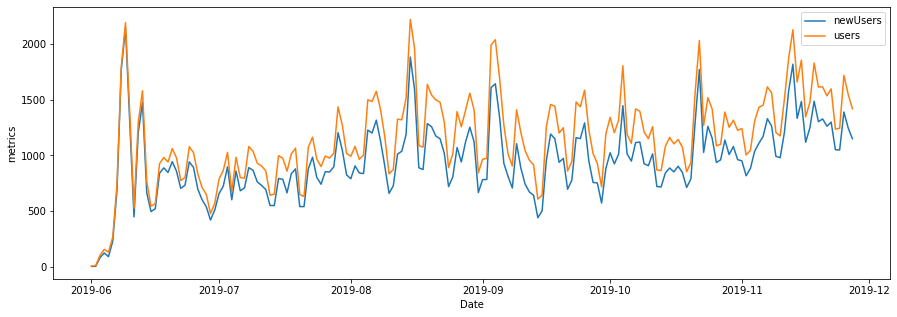

In [6]:
# ---------User count data
metrics='ga:newUsers,ga:users'
dimensions='ga:Date'

# ---------get results
results = s.get_results(service, profile,start_date,end_date,metrics,dimensions,view_id)
df = s.get_df(results,metrics,dimensions)
print (df[:10])

met = ['newUsers','users']
s.get_trend(df,'Date',met)

print ('null check::')
print (df.isnull().sum())


df_newuser = df[['Date','newUsers']]
df_alluser = df[['Date','users']]
df_newuser.index = pd.DatetimeIndex(df_newuser.Date, freq='D')
df_alluser.index = pd.DatetimeIndex(df_alluser.Date, freq='D')

# get_trend(df_newuser,'newUsers')
df_newuser.drop(columns='Date',axis=1,inplace=True)
df_alluser.drop(columns='Date',axis=1,inplace=True)

# df_alluser[:10]
# get_trend(df_alluser,'users')

##### Creating Exogenous variables

In [7]:
days = pd.date_range(start_date, end_date, freq='D')
days = pd.DataFrame({'Date':days})
days.set_index('Date',inplace=True)

data = days
data['month'] = data.index.month
data['day'] = data.index.day
data['weekday'] = data.index.weekday

cal = calendar()
holidays = cal.holidays(start=data.index.min(), end = data.index.max())
data['is_holiday'] = data.index.isin(holidays)
data['is_holiday'] = data['is_holiday'].astype(int)
data['is_weekend'] = data['weekday'].map(s.is_weekend)
data['is_weekday'] = np.where(data['is_weekend']==0,1,0)
data['holiday_weekday'] = np.where((data['is_weekday']==1)&(data['is_holiday']==1),1,0)
data['holiday_weekend'] = np.where((data['is_weekend']==1)&(data['is_holiday']==1),1,0)
data['inbetween25and5'] = np.where((data['day']>=25)|(data['day']<=5),1,0)

days = data.asfreq('D')
days[:5]

,month,day,weekday,is_holiday,is_weekend,is_weekday,holiday_weekday,holiday_weekend,inbetween25and5
Date,,,,,,,,,
2019-06-01,6,1,5,0,1,0,0,0,1
2019-06-02,6,2,6,0,1,0,0,0,1
2019-06-03,6,3,0,0,0,1,0,0,1
2019-06-04,6,4,1,0,0,1,0,0,1
2019-06-05,6,5,2,0,0,1,0,0,1


###### signup data pull

Sign Up               180
Next Step             175
Continue              172
Contact Us            171
Confirm Enrollment    161
Brokers                52
Businesses             29
My Account             21
continue               10
(not set)               4
Name: eventLabel, dtype: int64
76
0


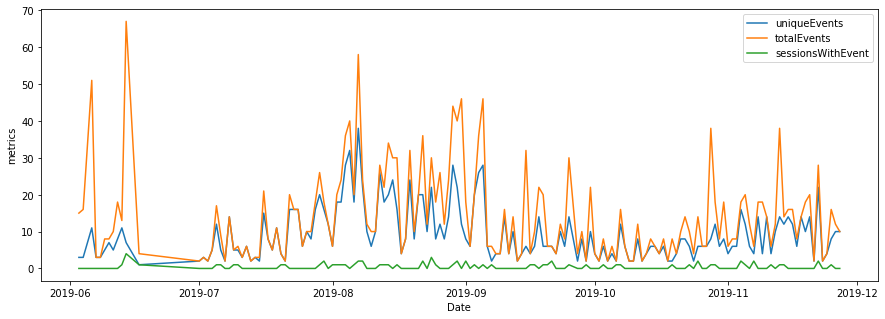

In [8]:
# ---------signup data
metrics='ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent'
dimensions='ga:Date,ga:eventLabel'

# ---------get results
results = s.get_results(service, profile,start_date,end_date,metrics,dimensions,view_id)
df = s.get_df(results,metrics,dimensions)
print (df['eventLabel'].value_counts())

# ---------filtering for 'sign up' event
df1 = df[(df['eventLabel']=='Confirm Enrollment')]
aggregation = {'uniqueEvents':sum,'totalEvents':sum,'sessionsWithEvent':sum,'eventsPerSessionWithEvent':sum}        
df2 = df1.groupby('Date').agg(aggregation)
df2.reset_index(inplace=True)

met = ['uniqueEvents','totalEvents','sessionsWithEvent'] 
s.get_trend(df2,'Date',met)

df2.set_index('Date',inplace=True)

df_signup = days.join(df2,on='Date',how='left')
print (df_signup.isnull().sum().sum())
df_signup = df_signup.fillna(0)
print (df_signup.isnull().sum().sum())
# df_signup[:10]


Index(['newUsers', 'month', 'day', 'weekday', 'is_holiday', 'is_weekend',
       'is_weekday', 'holiday_weekday', 'holiday_weekend', 'inbetween25and5',
       'signups', 'totalEvents', 'sessionsWithEvent',
       'eventsPerSessionWithEvent', 'perc_conversion'],
      dtype='object')


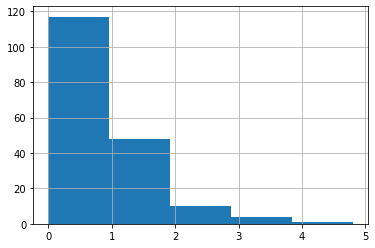

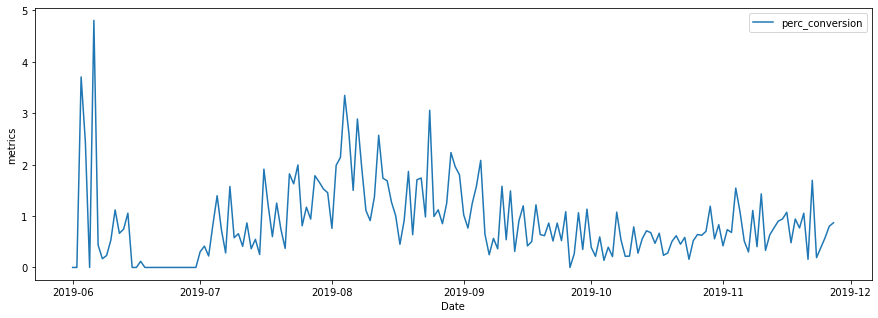

In [9]:
# --newusers and signups
df_prec_signup = df_newuser.join(df_signup, on='Date',how='inner')
df_prec_signup['perc_conversion'] = (1*df_prec_signup['uniqueEvents']/df_prec_signup['newUsers'])*100
df_prec_signup.rename(columns={'uniqueEvents':'signups'},inplace=True)
# print (df.isnull().sum())
# --0
# print (df_prec_signup.index)
# --DatetimeIndex

df_prec_signup['perc_conversion'].hist(bins=5)
print (df_prec_signup.columns)

df = df_prec_signup.reset_index()
met = ['perc_conversion']
s.get_trend(df,'Date',met)


## Forecasting

###### Define and run seasonal arima grid search

In [10]:
# --Define grid
p_params = [1,2,3]
d_params = [1,2]
q_params = [1,2,3]
t_params = ['n','c','t','ct']
P_params = [0,1,2,3]
D_params = [0,1,2,3]
Q_params = [0,1,2,3]
m_params = [5,7]

# --Call GridSearch

data = df_prec_signup['perc_conversion']#[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
# 	print(data)
# data split
n_test = 30
# model configs
cfg_list = s.sarima_configs(p_params,d_params,q_params,t_params,P_params,D_params,Q_params,m_params)
# grid search
scores = s.grid_search(data, cfg_list, n_test)
print('Done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)


 > Model[[(1, 1, 1), (0, 0, 0, 5), 'n']] 0.421
 > Model[[(1, 1, 1), (0, 0, 0, 7), 'n']] 0.421
 > Model[[(1, 1, 1), (0, 0, 1, 5), 'n']] 0.443
 > Model[[(1, 1, 1), (0, 0, 1, 7), 'n']] 0.452
 > Model[[(1, 1, 1), (0, 0, 2, 5), 'n']] 0.448
 > Model[[(1, 1, 1), (0, 0, 2, 7), 'n']] 0.447
 > Model[[(1, 1, 1), (0, 1, 0, 7), 'n']] 0.574
 > Model[[(1, 1, 1), (0, 0, 3, 5), 'n']] 0.444
 > Model[[(1, 1, 1), (0, 1, 0, 5), 'n']] 0.647
 > Model[[(1, 1, 1), (0, 1, 1, 5), 'n']] 0.486
 > Model[[(1, 1, 1), (0, 0, 3, 7), 'n']] 0.446
 > Model[[(1, 1, 1), (0, 1, 1, 7), 'n']] 0.488
 > Model[[(1, 1, 1), (0, 1, 2, 5), 'n']] 0.457
 > Model[[(1, 1, 1), (0, 2, 0, 5), 'n']] 1.093
 > Model[[(1, 1, 1), (0, 1, 2, 7), 'n']] 0.457
 > Model[[(1, 1, 1), (0, 2, 0, 7), 'n']] 0.968
 > Model[[(1, 1, 1), (0, 1, 3, 5), 'n']] 0.459
 > Model[[(1, 1, 1), (0, 2, 1, 5), 'n']] 0.656
 > Model[[(1, 1, 1), (0, 2, 1, 7), 'n']] 0.615
 > Model[[(1, 1, 1), (0, 1, 3, 7), 'n']] 0.458
 > Model[[(1, 1, 1), (0, 2, 2, 5), 'n']] 0.508
 > Model[[(1,

KeyboardInterrupt: 